In [6]:
import cartopy.crs as ccrs
import hvplot.xarray
import matplotlib as mpl

import xarray as xr

In [7]:
xr.set_options(display_style="html")

# Load data

In [41]:
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})

# we will add a gradient field with appropriate attributes
ds["dTdx"] = ds.Tair.differentiate("lon") / 110e3 / np.cos(ds.lat * np.pi / 180)
ds["dTdy"] = ds.Tair.differentiate("lat") / 105e3
ds.dTdx.attrs = {"long_name": "$∂T/∂x$", "units": "°C/m"}
ds.dTdy.attrs = {"long_name": "$∂T/∂y$", "units": "°C/m"}

ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 241.2 242.5 243.5 ... 296.49 296.19 295.69
    dTdx     (time, lat, lon) float32 1.826483e-05 ... -1.8823205e-06
    dTdy     (time, lat, lon) float32 -9.904727e-06 ... -1.9047619e-06
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This dataset has three variables, ``Tair`` is air temperature and ``dTdx`` and ``dTdy`` are horizontal gradients of this temperature field.

# Basic plotting

DataArray objects have a ``plot`` method that uses ``matplotlib``. By default ``.plot()`` makes
1. a line plot for 1-D arrays
2. a ``pcolormesh`` plot for 2-D arrays
3. a histogram for everything else

(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <a list of 10 Patch objects>)

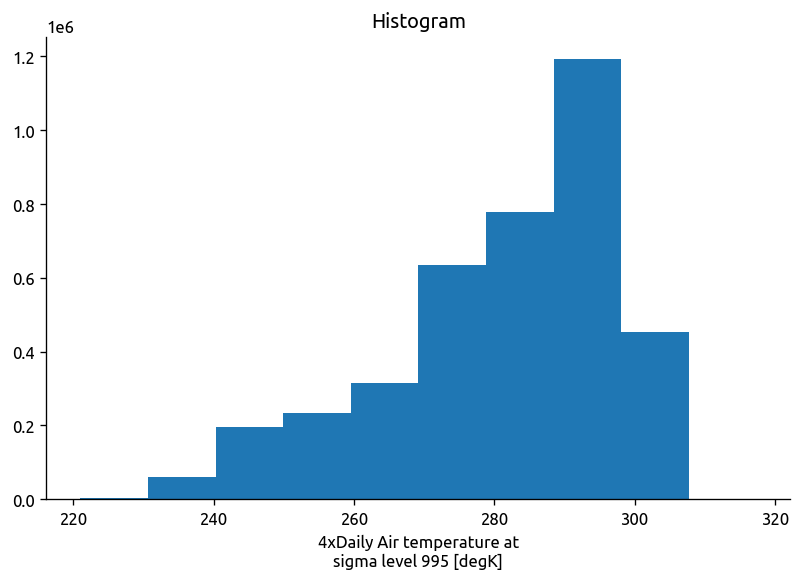

In [42]:
ds.Tair.plot()

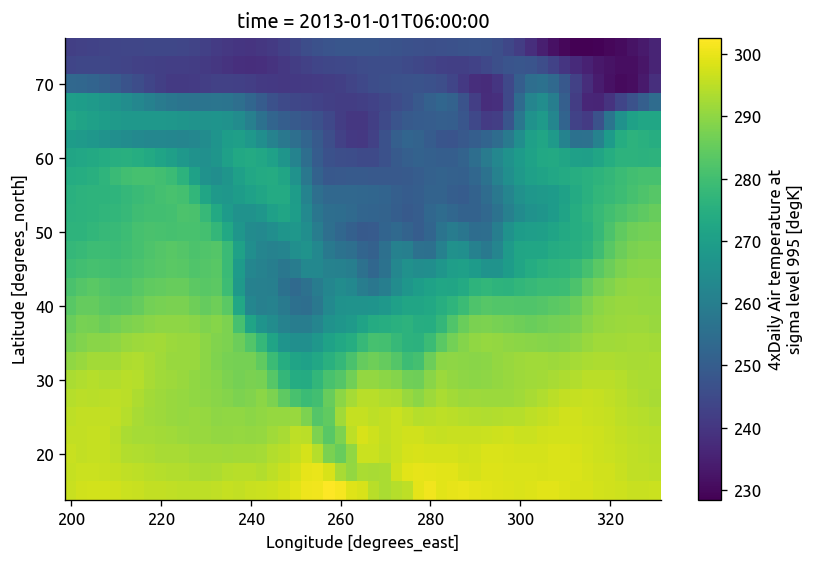

In [43]:
ds.Tair.isel(time=1).plot()

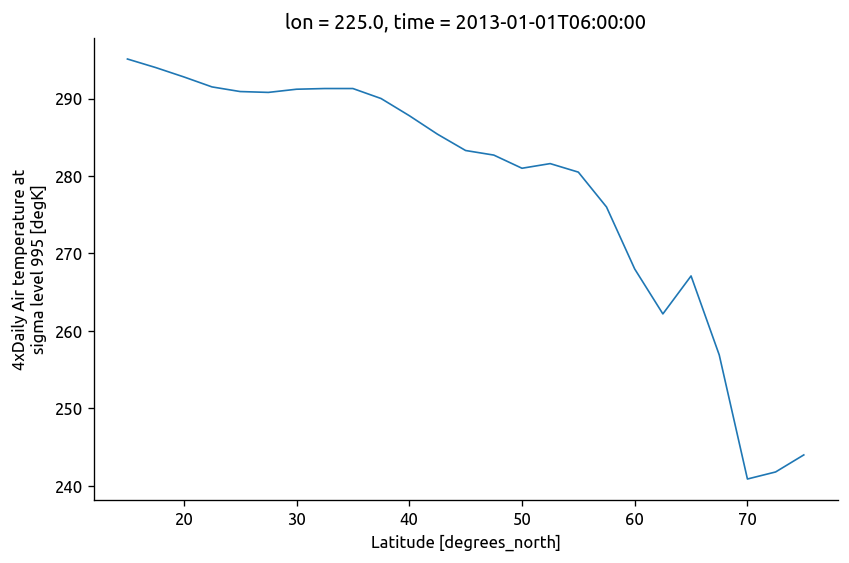

In [46]:
ds.Tair.isel(time=1, lon=10).plot()

# Customization

# Faceting

Faceting is the art of presenting "small multiples" of the data. We will use monthly means to illustrate

In [58]:
# This is a bad estimate that does not take into account the fact that months have different number of days.
monthly_means = ds.groupby("time.month").mean()
monthly_means

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, month: 12)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Tair     (month, lat, lon) float32 246.34987 246.38608 ... 297.53763
    dTdx     (month, lat, lon) float32 5.081737e-07 ... -1.042875e-07
    dTdy     (month, lat, lon) float32 -9.553304e-06 ... -3.871585e-06
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

The simplest way to facet is to specify the ``row`` or ``col`` kwargs which are expected to be a dimension name. Here we use ``month`` so that each panel or "facet" of the plot presents the mean temperature field in a given month. Since a 12 column plot would be too small to interpret, we can "wrap" the facets into multiple rows using ``col_wrap``

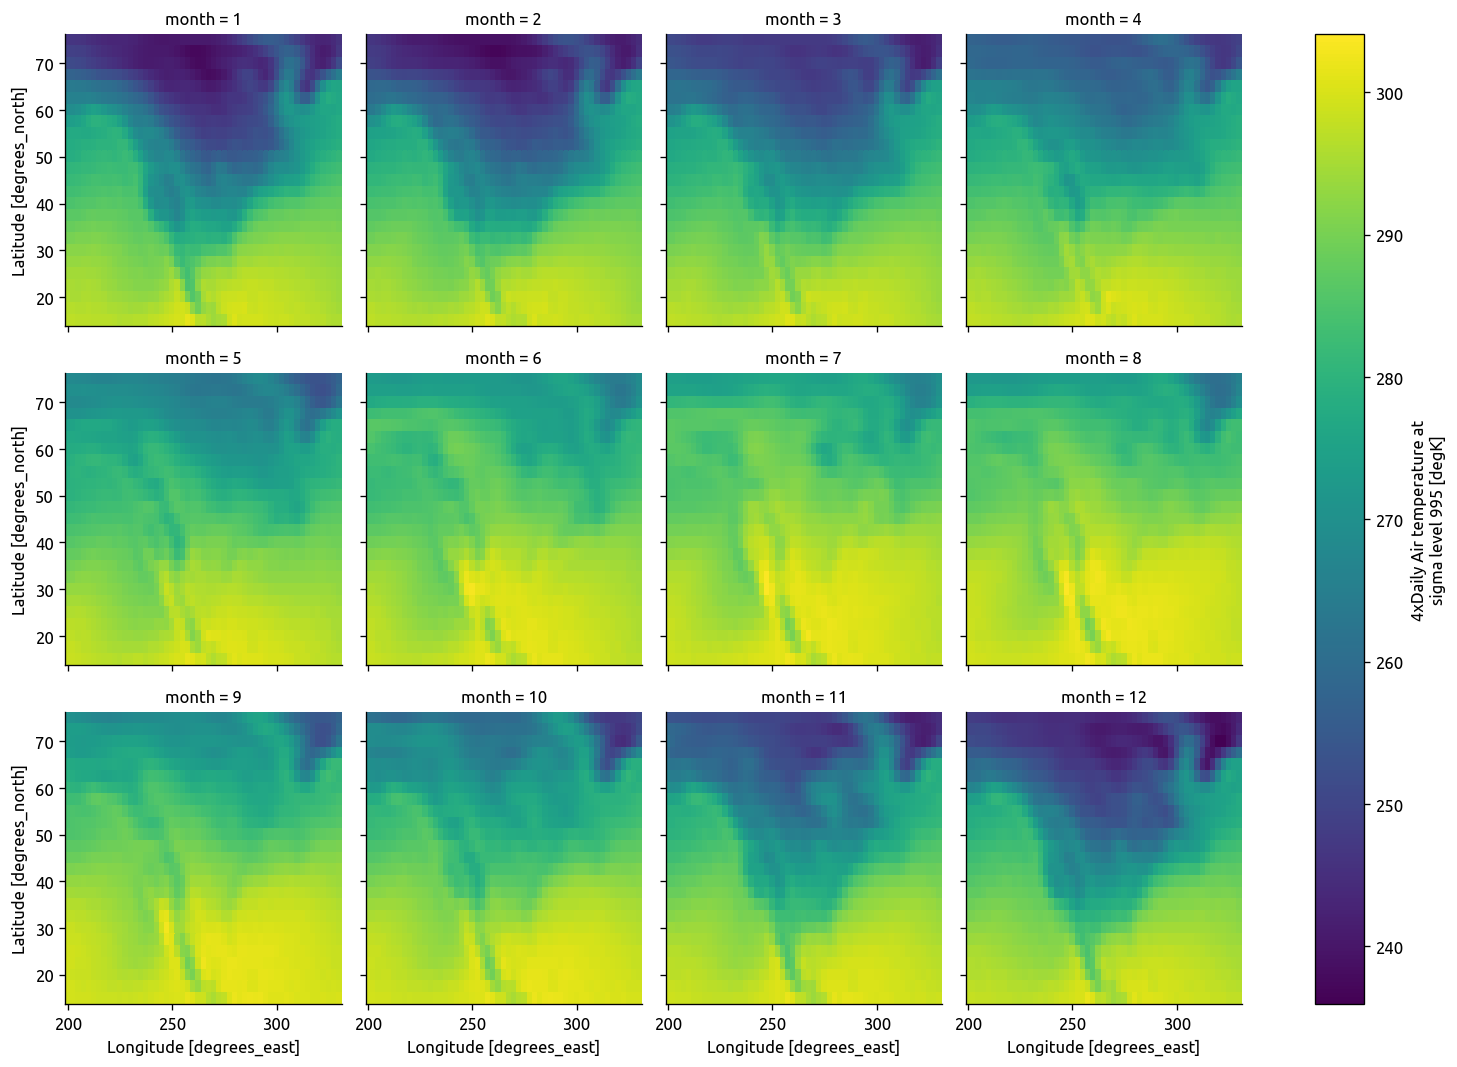

In [61]:
fg = monthly_means.Tair.plot(
    col="month", col_wrap=4,  # TODO: try commenting this line out
)

All the usual customizations are possible

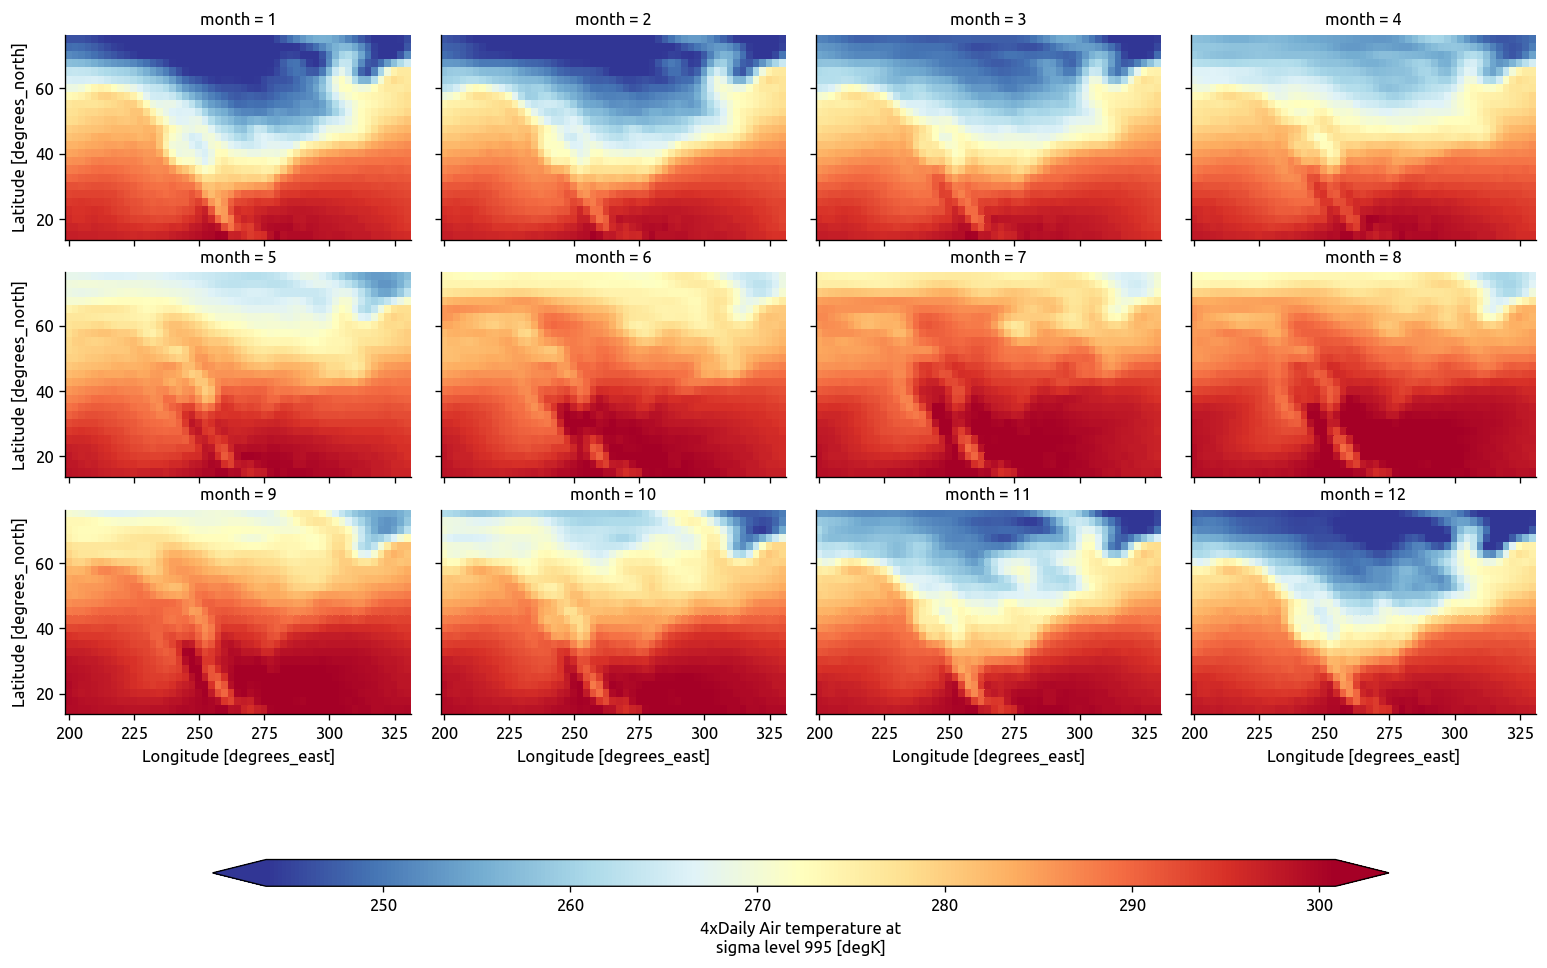

In [63]:
fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
)

#### Exercise

The returned FacetGrid object ``fg`` has many useful properties and methods e.g. 
1. ``fg.fig`` provides a handle to the figure
2. ``fg.axes`` is a numpy object array with handles to each individual axes
3. ``fg.set_xlabels`` and ``fg.set_ylabels`` can be used to change axes labels.

Use these properties to set a title for the figure.

## Tip: Use faceting to plot multiple DataArrays

Faceting can be used to plot multiple DataArrays in a Dataset. The trick is to use ``to_array()`` to convert a Dataset to a DataArray and thne facet that. 

This trick only works when it is sensible to use the same colormap and color scale for all DataArrays like with ``dTdx`` and ``dTdy``

In [66]:
gradients = monthly_means[["dTdx", "dTdy"]].to_array("gradient")
gradients

<xarray.DataArray (gradient: 2, month: 12, lat: 25, lon: 53)>
array([[[[ 5.08173684e-07, -9.46942578e-07, -4.03479180e-06, ...,
           1.00858488e-05,  1.81633768e-05,  2.19007525e-05],
         [ 6.02189118e-07, -8.90132014e-07, -4.25928238e-06, ...,
           1.44879168e-05,  3.15986872e-05,  3.92536967e-05],
         [-4.04702814e-06, -4.58570503e-06, -6.01438433e-06, ...,
           2.61500463e-05,  4.34150716e-05,  5.08334851e-05],
         ...,
         [-2.34571348e-06, -1.20601771e-06,  8.53055610e-07, ...,
          -1.45294723e-06, -2.20137940e-06, -2.35507150e-06],
         [-2.84735904e-07, -7.32893909e-07, -6.86845681e-07, ...,
          -1.83361863e-06, -1.57463614e-06, -2.10182111e-06],
         [ 3.16048641e-07, -1.98249467e-07, -4.91980586e-07, ...,
          -1.71716079e-06, -7.17862974e-07, -5.23411643e-07]],

        [[-3.81416953e-06, -5.11973212e-06, -8.09966514e-06, ...,
           1.27637104e-05,  1.81622308e-05,  2.02568535e-05],
         [-4.84793247e-07, -1.95023244e-06, -5.09623078e-06, ...,
           1.05404051e-05,  2.67223077e-05,  3.38635218e-05],
         [-5.29987710e-06, -5.99807481e-06, -7.59168552e-06, ...,
           2.05774650e-05,  3.87745931e-05,  4.66650490e-05],
         ...,
         [-1.97736995e-06, -1.47602975e-06,  5.62321816e-08, ...,
          -1.92044581e-06, -2.44147418e-06, -2.31803074e-06],
         [-5.83667656e-07, -1.20197819e-06, -1.22895858e-06, ...,
          -1.81083851e-06, -1.54249517e-06, -1.96479868e-06],
         [-2.72607025e-07, -8.11079019e-07, -8.67632082e-07, ...,
          -1.60114757e-06, -5.28392889e-07, -2.86215624e-07]],

        [[-4.94350161e-06, -5.91623620e-06, -7.80672599e-06, ...,
           1.05144391e-05,  1.48628014e-05,  1.67867292e-05],
         [-1.27851797e-06, -2.40904524e-06, -4.83539998e-06, ...,
           1.00647849e-05,  2.28014305e-05,  2.85018559e-05],
         [-3.99986811e-06, -4.43007821e-06, -5.47934997e-06, ...,
           1.94930271e-05,  3.75882628e-05,  4.51423293e-05],
         ...,
         [-1.58924797e-06, -8.35428693e-07,  8.79586366e-07, ...,
          -1.62646188e-06, -2.11556039e-06, -1.90116145e-06],
         [-5.87310538e-08, -6.11053679e-07, -6.60018657e-07, ...,
          -1.58347950e-06, -1.33172568e-06, -1.59431931e-06],
         [ 3.06636252e-07, -2.91760387e-07, -4.36651334e-07, ...,
          -1.50373035e-06, -5.99304713e-07, -3.56122143e-07]],

        ...,

        [[-8.44521037e-06, -9.20264938e-06, -1.02082167e-05, ...,
           9.99295207e-06,  1.56151382e-05,  1.89157163e-05],
         [-1.12393184e-06, -1.85974807e-06, -3.57176214e-06, ...,
           1.35889986e-05,  2.86205923e-05,  3.60447120e-05],
         [-8.97759946e-06, -6.30160321e-06, -1.95235089e-06, ...,
           2.79107626e-05,  4.61639829e-05,  5.39965185e-05],
         ...,
         [-3.06660831e-06, -2.13334692e-06, -6.86854351e-09, ...,
          -6.71587713e-07, -1.54742941e-06, -1.55023895e-06],
         [-7.36120114e-07, -1.32318792e-06, -1.30927754e-06, ...,
          -5.36719540e-07, -4.24714074e-07, -9.62734816e-07],
         [ 2.03716340e-07, -4.03636591e-07, -5.27809163e-07, ...,
          -8.07650281e-07,  7.21066229e-08,  3.73275327e-07]],

        [[-1.40205623e-06, -1.73953890e-06, -2.92792606e-06, ...,
           1.24338130e-05,  1.53239744e-05,  1.69657651e-05],
         [-6.05294008e-06, -5.67327197e-06, -5.89093861e-06, ...,
           8.12860435e-06,  2.18700170e-05,  2.88603878e-05],
         [-2.34648651e-05, -1.87677197e-05, -1.07571805e-05, ...,
           1.95673474e-05,  3.79640624e-05,  4.66431156e-05],
         ...,
         [-2.71639510e-06, -1.65399103e-06,  4.51308097e-07, ...,
          -6.97761550e-07, -1.56280817e-06, -1.57723809e-06],
         [-6.38807535e-07, -1.17951515e-06, -1.12137116e-06, ...,
          -6.59146224e-07, -4.87805266e-07, -1.08919608e-06],
         [ 1.70039058e-07, -3.58344295e-07, -4.57876553e-07, ...,
          -7.14653595e-07,  1.68152027e-07,  2.52540502e-07]],

    

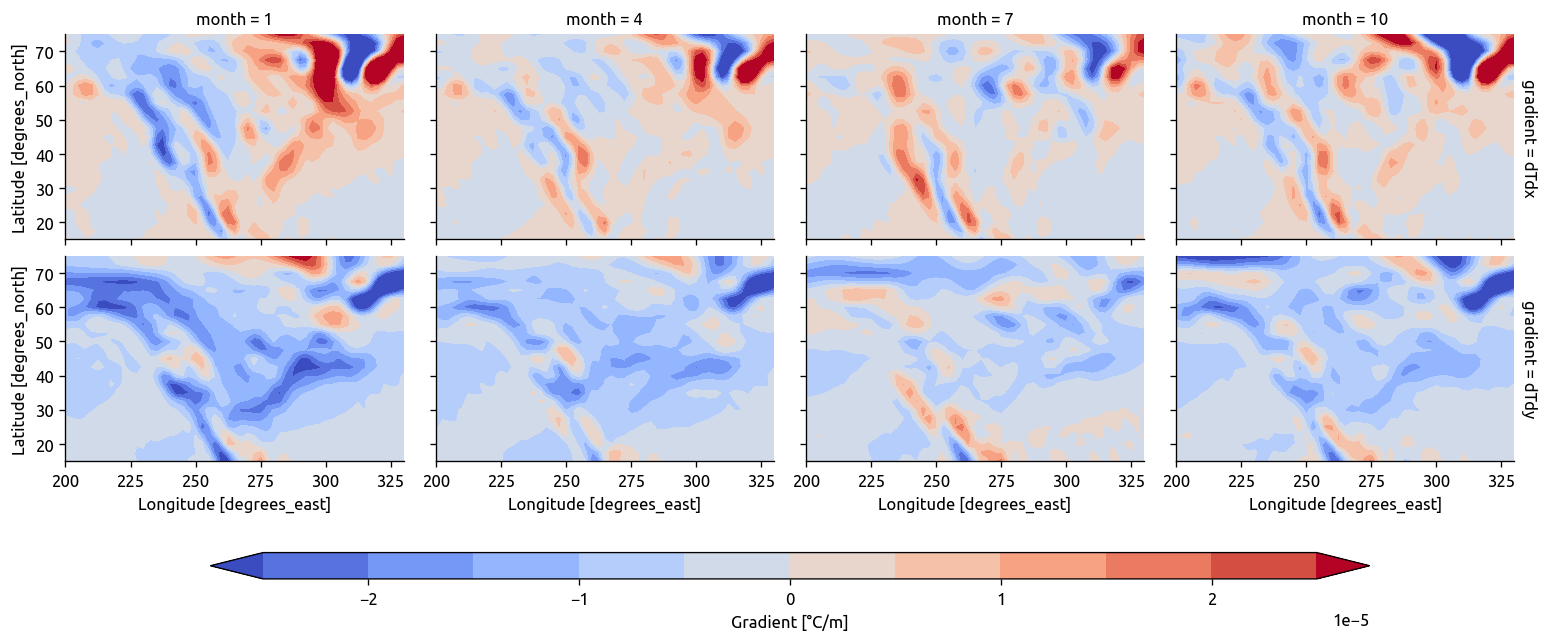

In [73]:
fg = gradients.isel(month=slice(None, None, 3)).plot.contourf(
    levels=13,
    col="month",
    row="gradient",
    robust=True,
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Gradient [°C/m]",
    },
)

## Modifying all facets of a plot

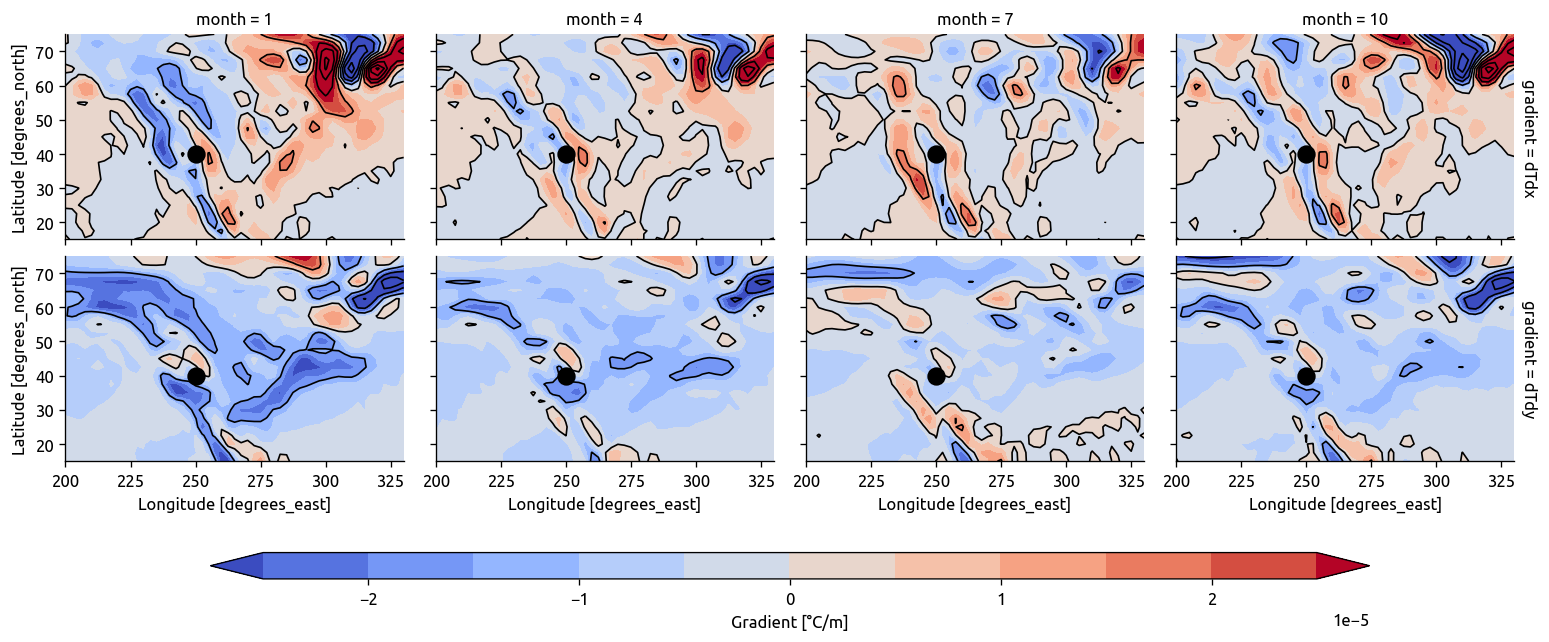

In [104]:
fg = gradients.isel(month=slice(None, None, 3)).plot.contourf(
    levels=13,
    col="month",
    row="gradient",
    robust=True,
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "label": "Gradient [°C/m]",
    },
)

fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)
fg.map(lambda: plt.plot(250, 40, markersize=20, marker=".", color="k"))

# Interactive bokeh plots using hvplot

In [86]:
import hvplot.xarray

### ``hvplot`` makes the same default choices as xarray 

In [87]:
ds.Tair.hvplot()

:NdOverlay   [Element]
   :Histogram   [Tair]   (Tair_count)

In [88]:
ds.Tair.isel(time=1).hvplot()

:Image   [lon,lat]   (Tair)

In [93]:
ds.Tair.isel(time=1, lon=1).hvplot()

:Curve   [lat]   (Tair)

## Interactivity 

But ``hvplot`` shines when interactivity is used. Here we can give it *all* the data and ask it to create a nice slider to control the time slice, and interactively visualize our data

In [94]:
ds.Tair.hvplot(groupby="time")

:DynamicMap   [time]
   :Image   [lon,lat]   (Tair)

Animations are easy

In [110]:
ds.Tair.hvplot(groupby="time", widget_type="scrubber", widget_location="bottom")

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=2919, width=550)
        [2] HSpacer()

# Geography

## matplotlib and cartopy

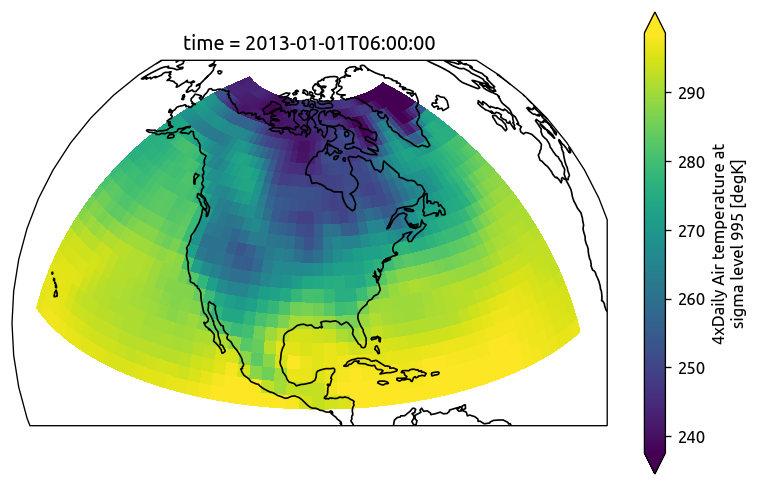

In [116]:
f, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Orthographic(-90, 30)))

ds.Tair.isel(time=1).plot(
    ax=ax, robust=True, transform=ccrs.PlateCarree(),
)
ax.coastlines()

## hvplot

In [119]:
ds.Tair.hvplot(
    groupby="time",
    widget_type="scrubber",
    widget_location="bottom",
    projection=ccrs.Orthographic(-90, 30),
    coastline=True,
)

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=2919, width=550)
        [2] HSpacer()